In [2]:
##Lets webscrap Toronto housing! 

In [137]:
from bs4 import BeautifulSoup # For HTML parsing
import requests # Website connections
from time import sleep # To prevent overwhelming the server between connections
from collections import Counter # Keep track of our term counts
import pandas as pd # For converting results to a dataframe and bar chart plots
import json # For parsing json
from requests import get
from random import randint
from warnings import warn
from time import time
from IPython.core.display import clear_output
import numpy as np

In [138]:
#get the first page of the Toronto housing prices
response = get('https://toronto.craigslist.org/search/apa')
#delete  post of an housing option without a pic using their filter

In [139]:
print(response.text[:500])

﻿<!DOCTYPE html>
<html class="no-js"><head>
    <title>toronto apts/housing for rent  - craigslist</title>

    <meta name="description" content="toronto apts/housing for rent  - craigslist">
    <meta http-equiv="X-UA-Compatible" content="IE=Edge"/>
    <link rel="canonical" href="https://toronto.craigslist.org/search/apa">
    <link rel="alternate" type="application/rss+xml" href="https://toronto.craigslist.org/search/apa?format=rss" title="RSS feed for craigslist | toronto apts/housing for re


In [140]:
html_soup = BeautifulSoup(response.text, 'html.parser')

In [141]:
type(html_soup)

bs4.BeautifulSoup

In [142]:
posts = html_soup.find_all('li', class_= 'result-row')
print(type(posts)) #to double check that I got a ResultSet
print(len(posts)) #to double check I got 50 (elements/page)

<class 'bs4.element.ResultSet'>
120


In [143]:
#The first post on craiglist
post_one = posts[0]
post_one

<li class="result-row" data-pid="6971631414">
<a class="result-image gallery" data-ids="1:01111_9wx67FMggzC,1:00F0F_hjdWucDaMuF,1:00N0N_46U5HENeahE,1:00X0X_iSkslM6zId5,1:00404_7Y31UvvIIW1,1:00g0g_26O0X0Qsdy4,1:00z0z_7MpPukkkHl0,1:00L0L_5n4UT9UnpXE" href="https://toronto.craigslist.org/tor/apa/d/toronto-beautiful-lower-penthouse-style/6971631414.html">
<span class="result-price">$2950</span>
</a>
<p class="result-info">
<span class="icon icon-star" role="button">
<span class="screen-reader-text">favorite this post</span>
</span>
<time class="result-date" datetime="2019-09-04 19:57" title="Wed 04 Sep 07:57:30 PM">Sep  4</time>
<a class="result-title hdrlnk" data-id="6971631414" href="https://toronto.craigslist.org/tor/apa/d/toronto-beautiful-lower-penthouse-style/6971631414.html">Beautiful Lower Penthouse-style Condo for rent</a>
<span class="result-meta">
<span class="result-price">$2950</span>
<span class="housing">
                    2br -
                    900ft<sup>2</sup> -
    

In [144]:
#grab the price of the first post
post_one_price = post_one.a.text
post_one_price

'\n$2950\n'

In [145]:
#grab the time of the post in datetime format to save on cleaning efforts
post_one_time = post_one.find('time', class_= 'result-date')
post_one_datetime = post_one_time['datetime']

#split them and grab each element of the resulting list to get date and time
post_one_datetime = post_one_datetime.split(' ')
post_one_date = post_one_datetime[0]
post_one_date

#element 2 is the time
post_one_time = post_one_datetime[1]

post_one_time

'19:57'

In [146]:
#title is a and that class, link is grabbing the href attribute of that variable
post_one_title = post_one.find('a', class_='result-title hdrlnk')
post_one_link = post_one_title['href']
post_one_link

'https://toronto.craigslist.org/tor/apa/d/toronto-beautiful-lower-penthouse-style/6971631414.html'

In [147]:
#easy to grab the post title by taking the text element of the title variable
post_one_title_text = post_one_title.text
post_one_title_text

'Beautiful Lower Penthouse-style Condo for rent'

In [148]:
#the neighborhood is grabbed by finding the span class 'result-hood' and pulling the text element from that
post_one_hood = post_one.find('span', class_= 'result-hood').text
post_one_hood

' (Regent Park)'

In [149]:
#getting sqft
post_one_sqft = post_one.find('span', class_ = 'housing').text.split()[2][:-3]
post_one_sqft

'900'

In [150]:
#find the total number of posts to find the limit of the pagination
results_num = html_soup.find('div', class_= 'search-legend')
results_total = int(results_num.find('span', class_='totalcount').text)

pages = np.arange(0, results_total, 120)

iterations = 0

post_timing = []
post_hoods = []
post_title_texts = []
post_links = []
post_prices = []
sqfts = []
bedroom_counts = []
for page in pages:
    
    #get request
    response = get("https://toronto.craigslist.org/search/eby/apt?" 
                   + "s=" 
                   + str(page) 
                   + "&hasPic=1"
                   + "&availabilityMode=0")

    sleep(randint(1,5))
     
    #throw warning for status codes that are not 200
    if response.status_code != 200:
        warn('Request: {}; Status code: {}'.format(requests, response.status_code))
        
    #define the html text
    page_html = BeautifulSoup(response.text, 'html.parser')
    
    #define the posts
    posts = html_soup.find_all('li', class_= 'result-row')
        
    #extract data item-wise
    for post in posts:

        if post.find('span', class_ = 'result-hood') is not None:

            #posting date
            #grab the datetime element 0 for date and 1 for time
            post_datetime = post.find('time', class_= 'result-date')['datetime']
            post_timing.append(post_datetime)

            #neighborhoods
            post_hood = post.find('span', class_= 'result-hood').text
            post_hoods.append(post_hood)

            #title text
            post_title = post.find('a', class_='result-title hdrlnk')
            post_title_text = post_title.text
            post_title_texts.append(post_title_text)

            #post link
            post_link = post_title['href']
            post_links.append(post_link)
            
            if post.find('span',class_ = 'result-price') is None:
                post_price = np.nan
            else:
                post_price = post.a.text.strip().replace("\n$", "")
                post_prices.append(post_price)
            if post.find('span', class_ = 'housing') is not None:
                
                #if the first element is accidentally square footage
                if 'ft2' in post.find('span', class_ = 'housing').text.split()[0]:
                    
                    #make bedroom nan
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                    
                    #make sqft the first element
                    sqft = int(post.find('span', class_ = 'housing').text.split()[0][:-3])
                    sqfts.append(sqft)
                    
                #if the length of the housing details element is more than 2
                elif len(post.find('span', class_ = 'housing').text.split()) > 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = int(post.find('span', class_ = 'housing').text.split()[2][:-3])
                    sqfts.append(sqft)
                    
                #if there is num bedrooms but no sqft
                elif len(post.find('span', class_ = 'housing').text.split()) == 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = np.nan
                    sqfts.append(sqft)                    
                
                else:
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                
                    sqft = np.nan
                    sqfts.append(sqft)
                
            #if none of those conditions catch, make bedroom nan, this won't be needed    
            else:
                bedroom_count = np.nan
                bedroom_counts.append(bedroom_count)
                
                sqft = np.nan
                sqfts.append(sqft)
            #    bedroom_counts.append(bedroom_count)
                
            #    sqft = np.nan
            #    sqfts.append(sqft)
                
                


    iterations += 1
    print("Finished iteration: " + str(iterations))

Finished iteration: 1
Finished iteration: 2
Finished iteration: 3
Finished iteration: 4
Finished iteration: 5
Finished iteration: 6
Finished iteration: 7
Finished iteration: 8
Finished iteration: 9
Finished iteration: 10
Finished iteration: 11
Finished iteration: 12
Finished iteration: 13
Finished iteration: 14
Finished iteration: 15
Finished iteration: 16
Finished iteration: 17
Finished iteration: 18
Finished iteration: 19
Finished iteration: 20
Finished iteration: 21
Finished iteration: 22
Finished iteration: 23
Finished iteration: 24
Finished iteration: 25


In [152]:
to_rooms.head(500)

,Date Posted,Neighborhood,Post Title,URL,Price,Sqft,Bedrooms
0,2019-09-04 19:43:00,Toronto,Stunning Waterfront Condo with Lake View (Nov 1),https://toronto.craigslist.org/tor/apa/d/toron...,2000,700.0,1.0
1,2019-09-04 19:40:00,352 Front St W,Live The Dream! Beautiful Condo Unit Toronto's...,https://toronto.craigslist.org/tor/apa/d/downt...,2550,699.0,1.0
3,2019-09-04 19:34:00,Entertainment District,Classy 3 Bedroom 2 Bathroom Corner Suite with ...,https://toronto.craigslist.org/tor/apa/d/downt...,4595,1200.0,3.0
4,2019-09-04 19:33:00,57 St Joseph St,Amazing 5 Star Condo in Cresford Living At 100...,https://toronto.craigslist.org/tor/apa/d/downt...,2550,599.0,1.0
8,2019-09-04 19:25:00,1121 Bay St,Open & Bright Condos On Bay Street Close To Yo...,https://toronto.craigslist.org/tor/apa/d/downt...,2550,599.0,1.0
9,2019-09-04 19:19:00,Yonge/Steeles,LUXURY 2BEDS 2BATHS CONDO 1PARKING INCLD,https://toronto.craigslist.org/tor/apa/d/thorn...,2500,850.0,2.0
10,2019-09-04 19:16:00,Kensington,Spacious 1 Bedroom Plus Den Loft with Balcony ...,https://toronto.craigslist.org/tor/apa/d/downt...,3950,1000.0,1.0
11,2019-09-04 19:16:00,87 Peter St,Noir-Brand New Condo 1 BR + Den In The Heart O...,https://toronto.craigslist.org/tor/apa/d/downt...,2550,599.0,1.0
17,2019-09-04 19:09:00,King West Village,Two Bedroom In The Heart Of King West,https://toronto.craigslist.org/tor/apa/d/york-...,3250,850.0,2.0
22,2019-09-04 18:38:00,Queen West,Beautiful 2 Bedroom Semi-Detached Home with Ga...,https://toronto.craigslist.org/tor/apa/d/west-...,5500,1500.0,2.0


In [158]:
import pandas as pd

to_rooms = pd.DataFrame({'Date Posted': post_timing,
                       'Neighborhood': post_hoods,
                       'Post Title': post_title_texts,
                       'URL': post_links,
                       'Price': post_prices,
                       'Sqft':sqfts,
                        'Bedrooms':bedroom_counts})

In [159]:
to_rooms.head(2000)

,Date Posted,Neighborhood,Post Title,URL,Price,Sqft,Bedrooms
0,2019-09-04 19:57,(Regent Park),Beautiful Lower Penthouse-style Condo for rent,https://toronto.craigslist.org/tor/apa/d/toron...,$2950,900.0,2
1,2019-09-04 19:51,(Church St/ Shuter St),*DOWNTOWN 1 BEDROOM FOR RENT*,https://toronto.craigslist.org/tor/apa/d/toron...,$2150,460.0,1
2,2019-09-04 19:49,(Yonge/Finch),"Furnished 3Br, 2Wr House near Finch Station, s...",https://toronto.craigslist.org/tor/apa/d/north...,$3500,NaN,3
3,2019-09-04 19:49,(35 Mariner Terr),"Stunning Luxury Condo With Lake, City And Roge...",https://toronto.craigslist.org/tor/apa/d/downt...,$2550,699.0,1
4,2019-09-04 19:43,(Toronto),Stunning Waterfront Condo with Lake View (Nov 1),https://toronto.craigslist.org/tor/apa/d/toron...,$2000,700.0,1
5,2019-09-04 19:40,(352 Front St W),Live The Dream! Beautiful Condo Unit Toronto's...,https://toronto.craigslist.org/tor/apa/d/downt...,$2550,699.0,1
6,2019-09-04 19:36,(brampton),one bedroom basement apartment with sep ent,https://toronto.craigslist.org/bra/apa/d/bramp...,,900.0,1
7,2019-09-04 19:34,(Entertainment District),Classy 3 Bedroom 2 Bathroom Corner Suite with ...,https://toronto.craigslist.org/tor/apa/d/downt...,$4595,1200.0,3
8,2019-09-04 19:33,(57 St Joseph St),Amazing 5 Star Condo in Cresford Living At 100...,https://toronto.craigslist.org/tor/apa/d/downt...,$2550,599.0,1
9,2019-09-04 19:30,(King West),Chic Studio Suite with Hardwood Floors and Bal...,https://toronto.craigslist.org/tor/apa/d/downt...,$3350,500.0,NaN


In [176]:
to_rooms.URL

0       https://toronto.craigslist.org/tor/apa/d/toron...
1       https://toronto.craigslist.org/tor/apa/d/toron...
3       https://toronto.craigslist.org/tor/apa/d/downt...
4       https://toronto.craigslist.org/tor/apa/d/toron...
5       https://toronto.craigslist.org/tor/apa/d/downt...
7       https://toronto.craigslist.org/tor/apa/d/downt...
8       https://toronto.craigslist.org/tor/apa/d/downt...
12      https://toronto.craigslist.org/tor/apa/d/downt...
13      https://toronto.craigslist.org/tor/apa/d/thorn...
14      https://toronto.craigslist.org/tor/apa/d/downt...
15      https://toronto.craigslist.org/tor/apa/d/downt...
21      https://toronto.craigslist.org/tor/apa/d/york-...
26      https://toronto.craigslist.org/tor/apa/d/west-...
27      https://toronto.craigslist.org/drh/apa/d/oshaw...
28      https://toronto.craigslist.org/tor/apa/d/east-...
29      https://toronto.craigslist.org/drh/apa/d/oshaw...
30      https://toronto.craigslist.org/drh/apa/d/oshaw...
31      https:

In [160]:
to_rooms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2325 entries, 0 to 2324
Data columns (total 7 columns):
Date Posted     2325 non-null object
Neighborhood    2325 non-null object
Post Title      2325 non-null object
URL             2325 non-null object
Price           2325 non-null object
Sqft            1200 non-null float64
Bedrooms        2225 non-null object
dtypes: float64(1), object(6)
memory usage: 127.2+ KB


In [162]:
to_rooms['Price']=to_rooms['Price'].str.replace('$','')
to_rooms['Neighborhood']=to_rooms['Neighborhood'].str.replace('(','')
to_rooms['Neighborhood']=to_rooms['Neighborhood'].str.replace(')','')
to_rooms['Bedrooms'] = to_rooms['Bedrooms'].apply(lambda x: float(x))
#to_rooms = to_rooms.drop_duplicates(subset='URL')
print(to_rooms.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2325 entries, 0 to 2324
Data columns (total 7 columns):
Date Posted     2325 non-null object
Neighborhood    2325 non-null object
Post Title      2325 non-null object
URL             2325 non-null object
Price           2325 non-null object
Sqft            1200 non-null float64
Bedrooms        2225 non-null float64
dtypes: float64(2), object(5)
memory usage: 127.2+ KB
None


In [163]:
to_rooms['Date Posted'] = pd.to_datetime(to_rooms['Date Posted'])
to_rooms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2325 entries, 0 to 2324
Data columns (total 7 columns):
Date Posted     2325 non-null datetime64[ns]
Neighborhood    2325 non-null object
Post Title      2325 non-null object
URL             2325 non-null object
Price           2325 non-null object
Sqft            1200 non-null float64
Bedrooms        2225 non-null float64
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 127.2+ KB


In [164]:
to_rooms['Price'] = to_rooms['Price'].astype(str)

In [165]:
import re

to_rooms['Price'] = to_rooms['Price'].apply(lambda x: re.sub(r'[\n$]+', '', x))

#replace '' with NaN values in the df before turning the column to int so data shape is maintained

In [166]:
import numpy as np
to_rooms['Price'].replace('', np.nan, inplace=True)

In [167]:
#drop the NAs because we dont like na
to_rooms = to_rooms.dropna()

In [168]:
to_rooms.info() #we still need to change the price to an int

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1050 entries, 0 to 2324
Data columns (total 7 columns):
Date Posted     1050 non-null datetime64[ns]
Neighborhood    1050 non-null object
Post Title      1050 non-null object
URL             1050 non-null object
Price           1050 non-null object
Sqft            1050 non-null float64
Bedrooms        1050 non-null float64
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 65.6+ KB


In [169]:
#now turn the price to int as well
to_rooms['Price'] = to_rooms['Price'].astype(int)

In [170]:
to_rooms.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1050 entries, 0 to 2324
Data columns (total 7 columns):
Date Posted     1050 non-null datetime64[ns]
Neighborhood    1050 non-null object
Post Title      1050 non-null object
URL             1050 non-null object
Price           1050 non-null int64
Sqft            1050 non-null float64
Bedrooms        1050 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 65.6+ KB


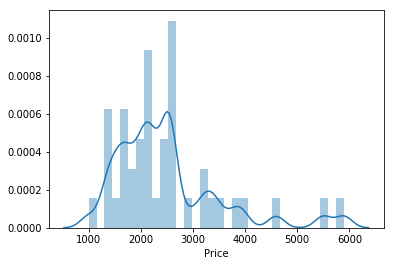

In [171]:
#start to look at the distributions
from matplotlib import figure
import matplotlib as plt
import seaborn as sns
%matplotlib inline

sns.distplot(to_rooms['Price']);

In [172]:
to_rooms.head(200)

,Date Posted,Neighborhood,Post Title,URL,Price,Sqft,Bedrooms
0,2019-09-04 19:57:00,Regent Park,Beautiful Lower Penthouse-style Condo for rent,https://toronto.craigslist.org/tor/apa/d/toron...,2950,900.0,2.0
1,2019-09-04 19:51:00,Church St/ Shuter St,*DOWNTOWN 1 BEDROOM FOR RENT*,https://toronto.craigslist.org/tor/apa/d/toron...,2150,460.0,1.0
3,2019-09-04 19:49:00,35 Mariner Terr,"Stunning Luxury Condo With Lake, City And Roge...",https://toronto.craigslist.org/tor/apa/d/downt...,2550,699.0,1.0
4,2019-09-04 19:43:00,Toronto,Stunning Waterfront Condo with Lake View (Nov 1),https://toronto.craigslist.org/tor/apa/d/toron...,2000,700.0,1.0
5,2019-09-04 19:40:00,352 Front St W,Live The Dream! Beautiful Condo Unit Toronto's...,https://toronto.craigslist.org/tor/apa/d/downt...,2550,699.0,1.0
7,2019-09-04 19:34:00,Entertainment District,Classy 3 Bedroom 2 Bathroom Corner Suite with ...,https://toronto.craigslist.org/tor/apa/d/downt...,4595,1200.0,3.0
8,2019-09-04 19:33:00,57 St Joseph St,Amazing 5 Star Condo in Cresford Living At 100...,https://toronto.craigslist.org/tor/apa/d/downt...,2550,599.0,1.0
12,2019-09-04 19:25:00,1121 Bay St,Open & Bright Condos On Bay Street Close To Yo...,https://toronto.craigslist.org/tor/apa/d/downt...,2550,599.0,1.0
13,2019-09-04 19:19:00,Yonge/Steeles,LUXURY 2BEDS 2BATHS CONDO 1PARKING INCLD,https://toronto.craigslist.org/tor/apa/d/thorn...,2500,850.0,2.0
14,2019-09-04 19:16:00,Kensington,Spacious 1 Bedroom Plus Den Loft with Balcony ...,https://toronto.craigslist.org/tor/apa/d/downt...,3950,1000.0,1.0


In [173]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats


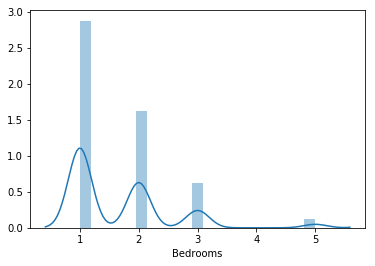

In [174]:
sns.distplot(to_rooms['Bedrooms'])

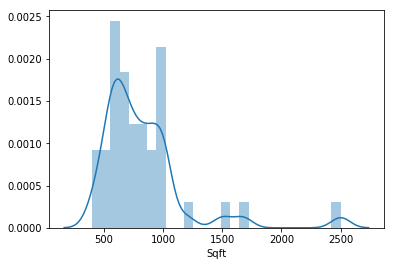

In [175]:
sns.distplot(to_rooms['Sqft'])